In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MambaBlock(nn.Module):
    def __init__(self, d_input, d_model):
        super().__init__()
        self.in_proj = nn.Linear(d_input, d_model)
        self.s_B = nn.Linear(d_model, d_model)
        self.s_C = nn.Linear(d_model, d_model)
        self.out_proj = nn.Linear(d_model, d_input)

    def forward(self, x):
        x_proj = self.in_proj(x)
        B, C = self.s_B(x_proj), self.s_C(x_proj)

        self.last_B = B.detach()
        self.last_C = C.detach()
        return self.out_proj(x_proj + B + C)

class Mamba(nn.Module):
    def __init__(self, num_layers, d_input, d_model, num_classes):
        super().__init__()
        self.layers = nn.ModuleList([MambaBlock(d_input, d_model) for _ in range(num_layers)])
        self.fc_out = nn.Linear(d_input, num_classes)
        self.attention_history = []
    def forward(self, x):
        self.attention_history = []
        for layer in self.layers:
            x = layer(x)
            self.attention_history.append((layer.last_B, layer.last_C))
        x = x.mean(dim=1)
        return self.fc_out(x)


transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            b, c, h, w = imgs.shape
            patch_size = 8
            x = imgs.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
            x = x.contiguous().view(b, c, -1, patch_size*patch_size)
            x = x.permute(0, 2, 3, 1).reshape(b, -1, patch_size*patch_size*c)
            output = model(x)
            _, pred = torch.max(output, 1)
            correct += (pred == labels).sum().item()
            total += labels.size(0)
    return correct / total

losses = []
accuracies = []

def train_with_logging(model, train_loader, test_loader, optimizer, criterion, epochs=5):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            b, c, h, w = imgs.shape
            patch_size = 8
            x = imgs.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
            x = x.contiguous().view(b, c, -1, patch_size*patch_size)
            x = x.permute(0, 2, 3, 1).reshape(b, -1, patch_size*patch_size*c)

            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        acc = evaluate(model, test_loader)
        accuracies.append(acc)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {acc:.4f}")

input_dim = 8*8*3
num_classes = 10

model = Mamba(num_layers=3, d_input=input_dim, d_model=128, num_classes=num_classes).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

train_with_logging(model, train_loader, test_loader, optimizer, criterion, epochs=5)



100%|██████████| 170M/170M [00:02<00:00, 73.7MB/s]


Epoch 1, Loss: 2.1192, Accuracy: 0.2028
Epoch 2, Loss: 2.0815, Accuracy: 0.1947
Epoch 3, Loss: 2.0712, Accuracy: 0.2363
Epoch 4, Loss: 2.0634, Accuracy: 0.2087
Epoch 5, Loss: 2.0588, Accuracy: 0.2201


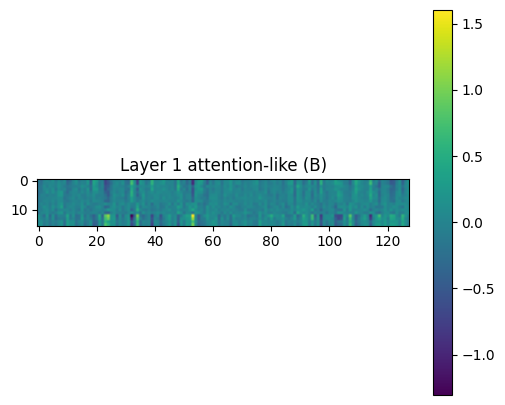

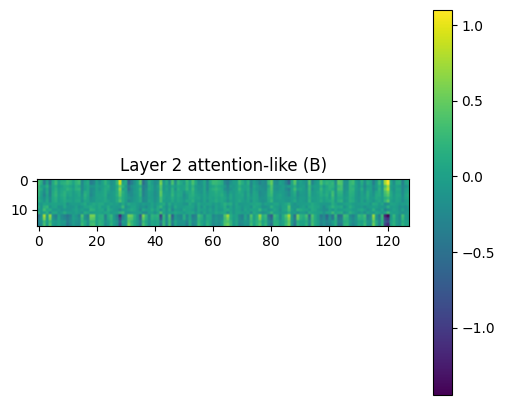

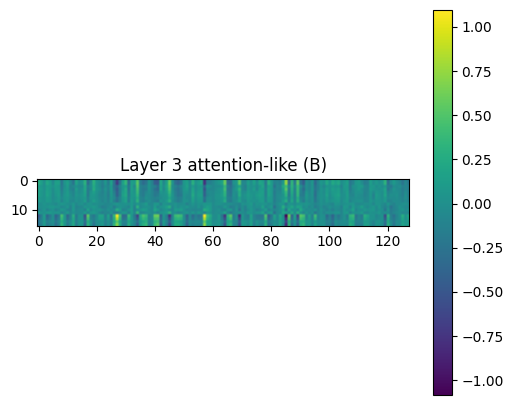

In [2]:
model.eval()
with torch.no_grad():
    imgs, labels = next(iter(test_loader))
    b, c, h, w = imgs.shape
    patch_size = 8
    x = imgs.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    x = x.contiguous().view(b, c, -1, patch_size*patch_size)
    x = x.permute(0, 2, 3, 1).reshape(b, -1, patch_size*patch_size*c)
    _ = model(x)

for i, (B, C) in enumerate(model.attention_history):
    plt.figure(figsize=(6,5))
    plt.imshow(B[0].cpu(), cmap='viridis')
    plt.title(f"Layer {i+1} attention-like (B)")
    plt.colorbar()
    plt.show()

# Вывод

Mamba на этом датасете научилась различать классы CIFAR-10 на базовом уровне. Вероятно, для улучшения результатов требуется больше эпох обучения и увеличение размерности скрытых представлений (hidden dims) внутри Mamba-блоков